In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [2]:
ETF_data_file = 'GSPC.csv'
date_column = 'Date'
price_column = 'Close'

hold_duration_years = 20
hold_duration_days = 252*hold_duration_years

start_date = '0000-01-01'
end_date = '2023-01-01'

In [3]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}), (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date


date = '9/17/2015'
date = 'Jun 14 2022'
date = 'Apr 01, 1929'

date_normalize(
    date,
    )

'1929-04-01'

In [4]:
def str_to_float(input):
    try:
        return float(re.sub(r'[^\d\.]', r'', input))
    except:
        return input

In [5]:
if '.csv' in ETF_data_file.lower():
    data = pd.read_csv(
        ETF_data_file,
        )
else:
    data = pd.read_excel(
        ETF_data_file,
        )

data[date_column] = data[date_column].apply(date_normalize)
data[price_column] = data[price_column].apply(str_to_float)

data = pysqldf(u"""
    select 
    {} as date,
    {} as price
    from data
    """.format(
    date_column, 
    price_column
   ))

data = pysqldf(u"""
    select *
    from data
    where date >= '{}' and date <= '{}'
    order by date asc
    """.format(
    start_date, 
    end_date))


data['id'] = data.index

In [6]:
data.head(3)

,date,price,id
0,1927-12-30,17.66,0
1,1928-01-03,17.76,1
2,1928-01-04,17.72,2


# the return

In [7]:
holding = pysqldf(u"""
    select 
    data.date,
    data.price,
    pre_data.date as pre_date,
    pre_data.price as pre_price,
    data.price/pre_data.price as price_ratio
    from data
    join data as pre_data on pre_data.id+{} = data.id
    """.format(hold_duration_days))

In [8]:
holding.head(3)

,date,price,pre_date,pre_price,price_ratio
0,1948-03-09,13.95,1927-12-30,17.66,0.789921
1,1948-03-10,14.01,1928-01-03,17.76,0.788851
2,1948-03-11,13.99,1928-01-04,17.72,0.789503


<AxesSubplot:xlabel='date'>

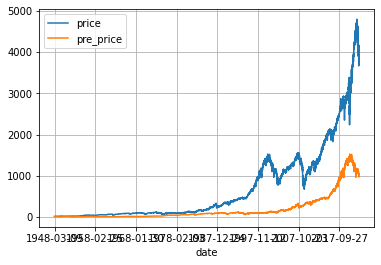

In [9]:
holding.plot(x ='date', y=[
    'price', 
    'pre_price', 
    ], grid = True)

<AxesSubplot:xlabel='date'>

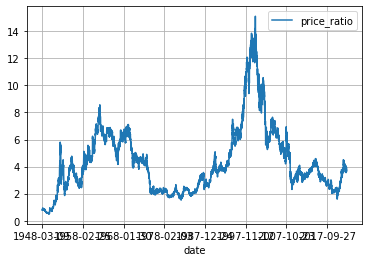

In [10]:
holding.plot(x ='date', y=[
    'price_ratio', 
    ], grid = True)

<AxesSubplot:>

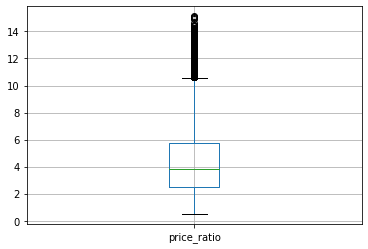

In [11]:
holding.boxplot(column=['price_ratio']) 

In [12]:
price_ratio = holding['price_ratio'].median()

print('Ratio:\t%0.4f'%(price_ratio))

Ratio:	3.7964


END